Trabalho de Mineração de dados UFPE 2024.1
Grupo: Geraldo Siqueira, Lívia Souza, Silvio Caetano e Victor Borges

## Pre processamento do banco de dados : Url prediction

Bibliotecas necessarias:

In [ ]:
pip install graphviz pydotplus

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle
import re
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import seaborn as sns
from sklearn.tree import export_text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importação do banco de dados

In [ ]:
URL = '/content/drive/MyDrive/Mineracao_Dados/urldata.csv'

#URL = pd.read_csv('dataset = pd.read_csv('https://raw.githubusercontent.com/liviasouza01/PhishingDataMining/main/Dataset/urldata%202.csv')

Url_data = pd.read_csv(URL)

In [ ]:
Url_data.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


## Pre-Processamento

### Tamanho do banco de dados, de acordo com as URL

In [ ]:
len(Url_data)


420464

### Remoção de duplicadas


In [ ]:
# Remover duplicatas e contar quantas foram removidas
num_duplicatas_removidas = len(Url_data) - len(Url_data.drop_duplicates())

# Remover duplicatas
Url_data_sem_duplicatas = Url_data.drop_duplicates()

# Exibir o número de duplicatas removidas
print("Número de duplicatas removidas:", num_duplicatas_removidas)


Número de duplicatas removidas: 9216


### Novo tamanho do banco de dados após a remoção das duplicadas

In [ ]:
len(Url_data_sem_duplicatas)

411248

### Remoção dos valores ausentes no banco de dados


In [ ]:
# Remover valores ausentes
Url_data_sem_ausentes = Url_data_sem_duplicatas.dropna()

# Verificar se há valores ausentes após a remoção
print("Valores ausentes após a remoção:", Url_data_sem_ausentes.isnull().sum().sum())

Valores ausentes após a remoção: 0


### Compreensão das classes

In [ ]:
label_map = {'bad': "malicious", 'good': "benign"}

# use the map() method to replace the labels with numerical values
Url_data_sem_ausentes['label'] = Url_data_sem_ausentes['label'].map(label_map)
# Print all unique values in the 'label' column
print(Url_data_sem_ausentes['label'].unique())

['malicious' 'benign']


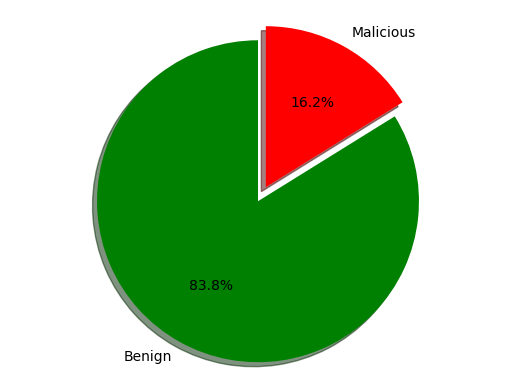

In [ ]:
# calculate the percentage of 'benign' and 'malicious' labels
label_counts = Url_data_sem_ausentes['label'].value_counts(normalize=True)
benign_percent = label_counts['benign'] * 100
malicious_percent = label_counts['malicious'] * 100

# create a pie chart
labels = ['Benign', 'Malicious']
sizes = [benign_percent, malicious_percent]
colors = ['green', 'red']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')

plt.show()

### Extração de caracteres

O pacote re em Python é a biblioteca padrão para expressões regulares, fornecendo funcionalidades para trabalhar com padrões de texto e realizar operações complexas de pesquisa e manipulação de strings.

Expressões regulares são sequências de caracteres que definem um padrão de busca em texto. Elas são extremamente úteis quando você precisa realizar operações como encontrar todas as ocorrências de um determinado padrão em um texto, substituir partes de um texto com base em um padrão ou validar se uma string corresponde a um determinado padrão.

In [ ]:
# Função para extrair o número de símbolos no URL:

# Esta função conta o número de símbolos especiais no URL.
# O padrão de expressão regular r'[\/\-\.\@\?\&\=\;\#]' procura
# por símbolos como '/', '-', '.', '@', '?', '&', '=', ';' e '#'.

def count_symbols(url):
    symbols = re.findall(r'[\/\-\.\@\?\&\=\;\#]', url)
    return len(symbols)


#_____________________________________________________________________________________
# Função para extrair a quantidade de dígitos no URL

# Esta função conta o número de dígitos presentes no URL.
# O padrão de expressão regular r'\d' procura por qualquer dígito de 0 a 9.

def count_digits(url):
    digits = re.findall(r'\d', url)
    return len(digits)

#___________________________________________________________________________________
# Função para extrair o comprimento das diferentes partes do URL

# Esta função calcula o comprimento de cada parte do URL após dividi-lo pela barra '/'.
# Retorna uma lista com o comprimento de cada parte.

def url_lengths(url):
    parts = url.split('/')
    lengths = [len(part) for part in parts]
    return lengths

#_____________________________________________________________________________________
# Função para extrair o nível do subdomínio

# Esta função calcula o nível do subdomínio contando o número
# de partes separadas por pontos '.' após o protocolo


def subdomain_level(url):
    subdomain = url.split('//')[-1].split('/')[0].split('.')
    return len(subdomain)

#______________________________________________________________________________________
# Função para extrair o grau de aleatoriedade do domínio

# Esta função calcula o grau de aleatoriedade do domínio dividindo o
# comprimento do domínio pelo número de caracteres únicos no domínio.

def domain_entropy(url):
    domain = re.sub(r'^https?://(?:www\.)?', '', url).split('/')[0]
    unique_chars = set(domain)
    return len(domain) / len(unique_chars)

#______________________________________________________________________________________
# Função para extrair a identificação de top-level domains (TLDs) conhecidos

# Esta função extrai o Top-Level Domain (TLD) conhecido da URL.
# Procura por uma sequência de caracteres após o último ponto '.' na URL.

def extract_tld(url):
    tld = re.findall(r'\.(\w+)$', url)
    return tld[0] if tld else None

#_______________________________________________________________________________________

# Função para extrair a presença de 'www' ou 'com' em locais distintos do TLD

# Esta função verifica se 'www' e 'com' estão presentes em locais distintos do TLD na URL.
def check_www_com(url):
    domain = re.sub(r'^https?://(?:www\.)?', '', url).split('/')[0]
    www_present = 'www' in domain
    com_present = 'com' in domain
    return www_present, com_present

#_______________________________________________________________________________________

# Função para extrair métricas de palavras

# Esta função calcula métricas relacionadas às palavras presentes na URL,
# como o comprimento máximo, mínimo e médio das palavras, além de outras estatísticas
def word_metrics(url):
    words = re.findall(r'\b\w+\b', url)
    if not words:
        return {
            'max_word_length': 0,
            'min_word_length': 0,
            'mean_word_length': 0,
            'std_word_length': 0,
            'total_words': 0,
            'compound_words': 0,
            'famous_word_count': 0
        }
    metrics = {
        'max_word_length': max(len(word) for word in words),
        'min_word_length': min(len(word) for word in words),
        'mean_word_length': sum(len(word) for word in words) / len(words),
        'std_word_length': np.std([len(word) for word in words]),
        'total_words': len(words),
        'compound_words': sum(1 for word in words if len(word) > 1),
        'famous_word_count': sum(1 for word in words if word.lower() in ['secure', 'login', ...]) # Adicione outras palavras-chave aqui
    }
    return metrics

#_____________________________________________________________________________________________________
# Função para contar caracteres consecutivos na URL

# Esta função conta o número máximo de caracteres consecutivos em cada parte da URL.

def consecutive_chars(url):
    max_consecutive = 0
    parts = url.split('/')
    for part in parts:
        consecutive_chars = re.findall(r'((\w)\2*)', part)
        if consecutive_chars:
            max_consecutive = max(max_consecutive, len(max(consecutive_chars, key=len)[0]))
    return max_consecutive

#__________________________________________________________________________________________________

# Função para verificar a utilização de punycode

# Esta função verifica se a URL utiliza punycode, o que é comum em URLs internacionais

def check_punycode(url):
    if 'xn--' in url:
        return True
    else:
        return False

In [ ]:
# Aplicar funções ao DataFrame
Url_data_sem_ausentes['symbols_count'] = Url_data_sem_ausentes['url'].apply(count_symbols)
Url_data_sem_ausentes['digits_count'] = Url_data_sem_ausentes['url'].apply(count_digits)
Url_data_sem_ausentes['url_lengths'] = Url_data_sem_ausentes['url'].apply(url_lengths)
Url_data_sem_ausentes['subdomain_level'] = Url_data_sem_ausentes['url'].apply(subdomain_level)
Url_data_sem_ausentes['domain_entropy'] = Url_data_sem_ausentes['url'].apply(domain_entropy)
Url_data_sem_ausentes['tld'] = Url_data_sem_ausentes['url'].apply(extract_tld)
Url_data_sem_ausentes['www_present'], Url_data_sem_ausentes['com_present'] = zip(*Url_data_sem_ausentes['url'].apply(check_www_com))
Url_data_sem_ausentes['word_metrics'] = Url_data_sem_ausentes['url'].apply(word_metrics)
Url_data_sem_ausentes['consecutive_chars'] = Url_data_sem_ausentes['url'].apply(consecutive_chars)
Url_data_sem_ausentes['punycode'] = Url_data_sem_ausentes['url'].apply(check_punycode)


### Resultados gerados

In [ ]:
Url_data_sem_ausentes.head()

,url,label,symbols_count,digits_count,url_lengths,subdomain_level,domain_entropy,tld,www_present,com_present,word_metrics,consecutive_chars,punycode
0,diaryofagameaddict.com,malicious,1,0,[22],2,1.692308,com,False,True,"{'max_word_length': 18, 'min_word_length': 3, ...",1,False
1,espdesign.com.au,malicious,2,0,[16],3,1.230769,au,False,True,"{'max_word_length': 9, 'min_word_length': 2, '...",1,False
2,iamagameaddict.com,malicious,1,0,[18],2,1.800000,com,False,True,"{'max_word_length': 14, 'min_word_length': 3, ...",1,False
3,kalantzis.net,malicious,1,0,[13],2,1.300000,net,False,False,"{'max_word_length': 9, 'min_word_length': 3, '...",1,False
4,slightlyoffcenter.net,malicious,1,0,[21],2,1.500000,net,False,False,"{'max_word_length': 17, 'min_word_length': 3, ...",1,False


### Dados com as metricas para analise

In [ ]:
# Selecionando apenas as colunas desejadas
Url_metrics = Url_data_sem_ausentes[["url", "label", "word_metrics"]]

In [ ]:
# Separando as word_metrics em colunas individuais
word_metrics_df = Url_metrics['word_metrics'].apply(pd.Series)

# Concatenando as colunas de word_metrics com o banco de dados original
Url_metrics = pd.concat([Url_metrics, word_metrics_df], axis=1)

# Removendo a coluna original de word_metrics
Url_metrics.drop(columns=['word_metrics'], inplace=True)


In [ ]:
# Arredondando as colunas 'mean_word_length' e 'std_word_length' para 2 casas decimais
Url_metrics['mean_word_length'] = Url_metrics['mean_word_length'].round(2)
Url_metrics['std_word_length'] = Url_metrics['std_word_length'].round(2)

Url_metrics.head()

,url,label,max_word_length,min_word_length,mean_word_length,std_word_length,total_words,compound_words,famous_word_count
0,diaryofagameaddict.com,malicious,18.0,3.0,10.50,7.50,2.0,2.0,0.0
1,espdesign.com.au,malicious,9.0,2.0,4.67,3.09,3.0,3.0,0.0
2,iamagameaddict.com,malicious,14.0,3.0,8.50,5.50,2.0,2.0,0.0
3,kalantzis.net,malicious,9.0,3.0,6.00,3.00,2.0,2.0,0.0
4,slightlyoffcenter.net,malicious,17.0,3.0,10.00,7.00,2.0,2.0,0.0


### Gráficos dos atributos realizados

Grafico da função para extrair o número de símbolos no URL

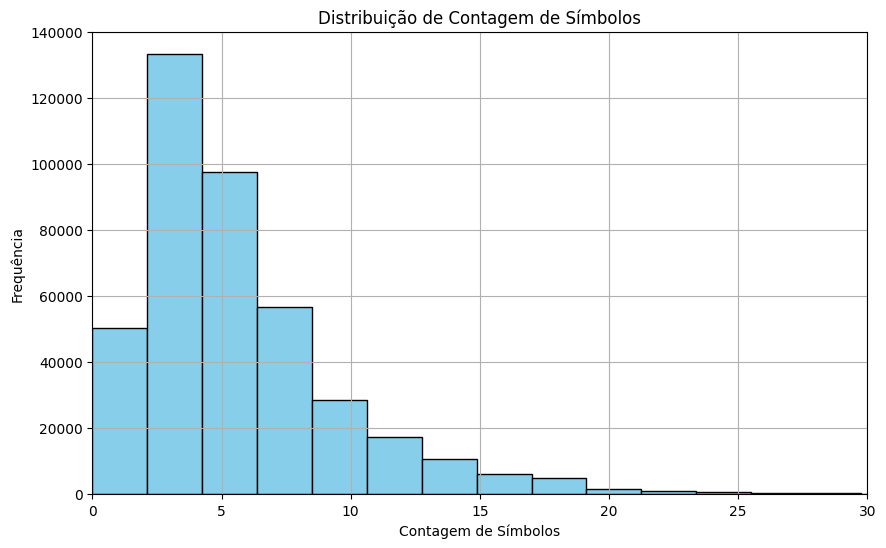

In [ ]:
# Gráfico de distribuição para symbols_count
plt.figure(figsize=(10, 6))
plt.hist(Url_data_sem_ausentes['symbols_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Distribuição de Contagem de Símbolos')
plt.xlabel('Contagem de Símbolos')
plt.ylabel('Frequência')
plt.grid(True)

# Ajustando os limites do eixo x de acordo com os dados
plt.xlim(0, 30)

plt.show()



Grafico da função para extrair a quantidade de dígitos no URL

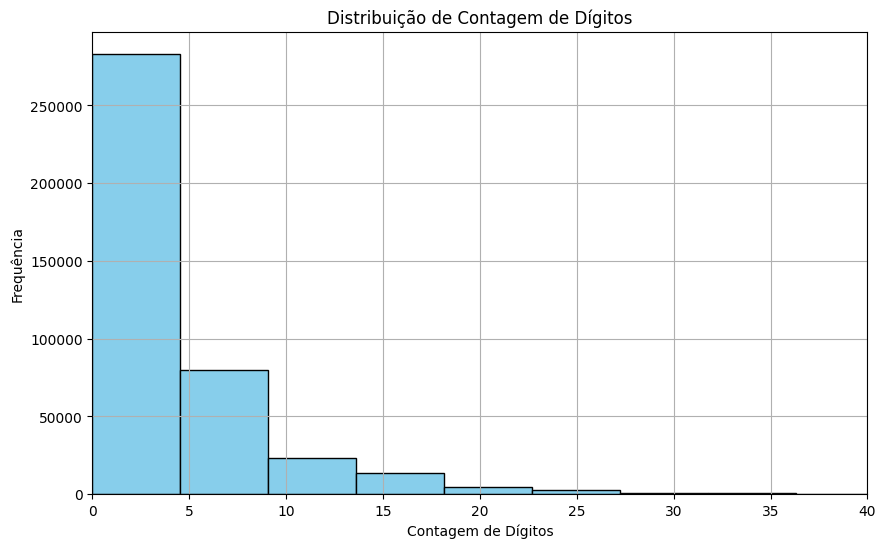

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(Url_data_sem_ausentes['digits_count'], bins=120, color='skyblue', edgecolor='black')
plt.title('Distribuição de Contagem de Dígitos')
plt.xlabel('Contagem de Dígitos')
plt.ylabel('Frequência')
plt.grid(True)

# Ajustando os limites do eixo x de acordo com os dados
plt.xlim(0, 40)

plt.show()


Grafico da função para extrair o comprimento das diferentes partes do URL

Grafico da função para extrair o nível do subdomínio

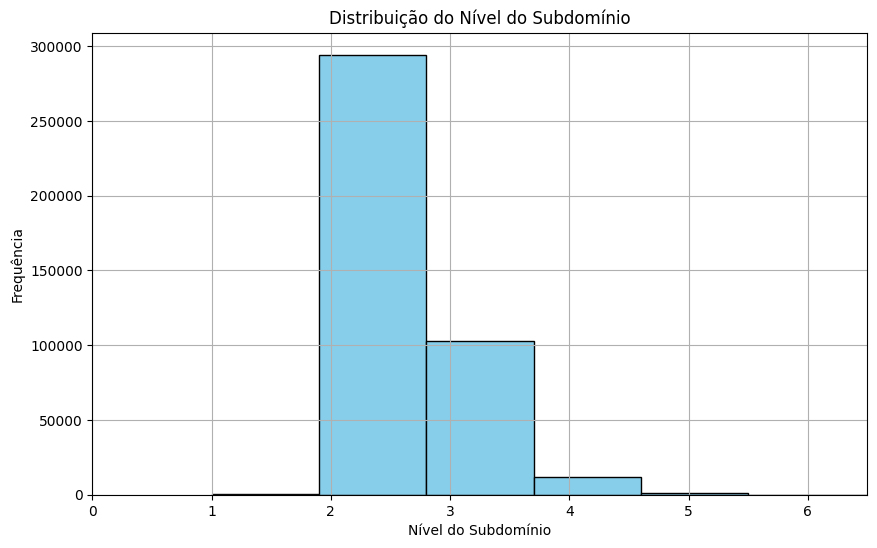

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(Url_data_sem_ausentes['subdomain_level'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição do Nível do Subdomínio')
plt.xlabel('Nível do Subdomínio')
plt.ylabel('Frequência')
plt.grid(True)

# Ajustando os limites do eixo x de acordo com os dados
plt.xlim(0, 6.5)

plt.show()


Grafico da função para extrair o grau de aleatoriedade do domínio

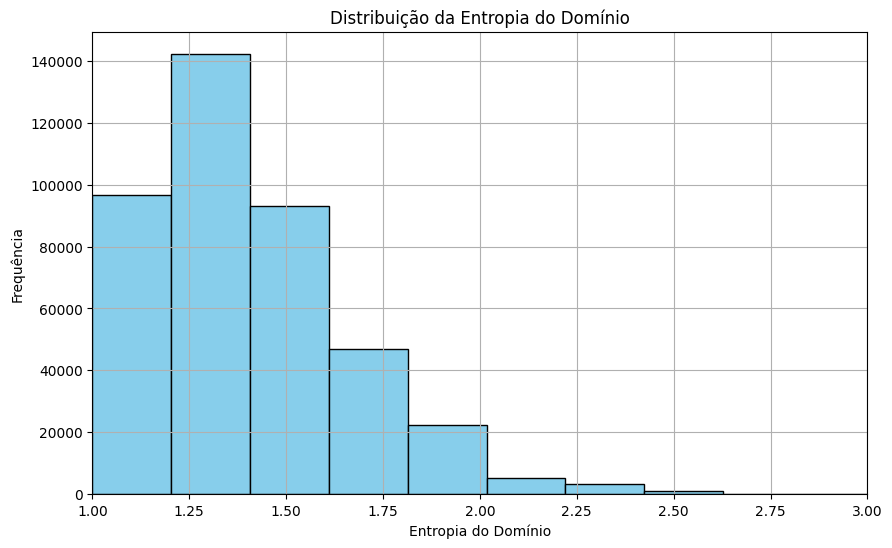

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(Url_data_sem_ausentes['domain_entropy'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribuição da Entropia do Domínio')
plt.xlabel('Entropia do Domínio')
plt.ylabel('Frequência')
plt.grid(True)

# Ajustando os limites do eixo x de acordo com os dados
plt.xlim(1, 3)
plt.show()


Grafico da função para extrair a identificação de top-level domains (TLDs) conhecidos

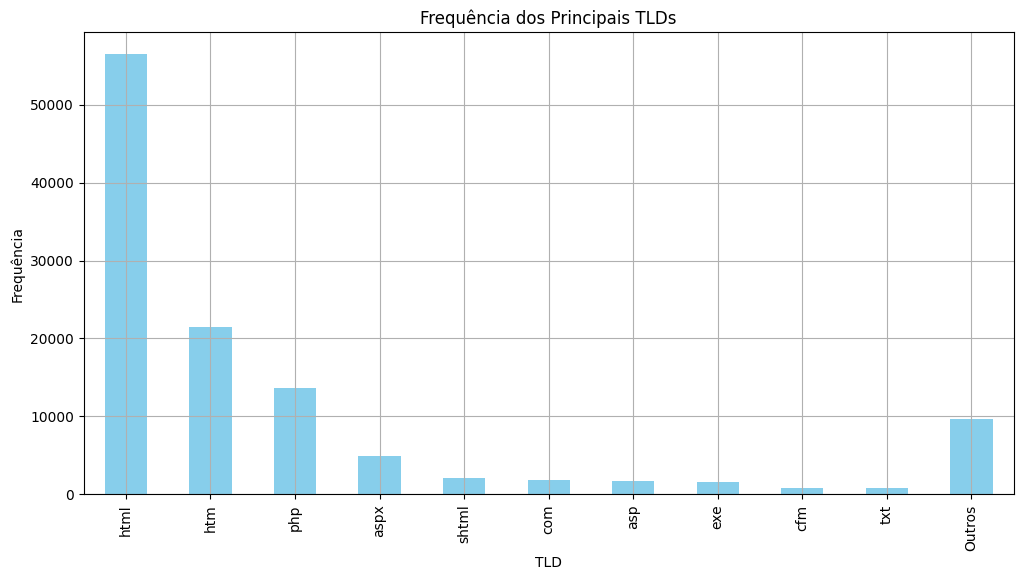

In [ ]:
# Contagem de frequência dos TLDs
tld_counts = Url_data_sem_ausentes['tld'].value_counts()

# Definindo o número de principais TLDs a serem mostrados
top_n = 10

# Verificando se o número de TLDs é maior que o número máximo a ser mostrado
if len(tld_counts) > top_n:
    # Selecionando os N principais TLDs
    top_tlds = tld_counts.head(top_n)

    # Calculando a contagem de TLDs restantes
    other_tlds_count = tld_counts.iloc[top_n:].sum()

    # Agrupando os TLDs menos frequentes em uma categoria "Outros"
    top_tlds['Outros'] = other_tlds_count

    # Criando o gráfico de barras
    plt.figure(figsize=(12, 6))
    top_tlds.plot(kind='bar', color='skyblue')
    plt.title('Frequência dos Principais TLDs')
    plt.xlabel('TLD')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()
else:
    # Se o número de TLDs for menor que o número máximo a ser mostrado, criar o gráfico normalmente
    plt.figure(figsize=(12, 6))
    tld_counts.plot(kind='bar', color='skyblue')
    plt.title('Frequência dos TLDs')
    plt.xlabel('TLD')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()


Grafico da função para extrair a presença de 'www' ou 'com' em locais distintos do TLD

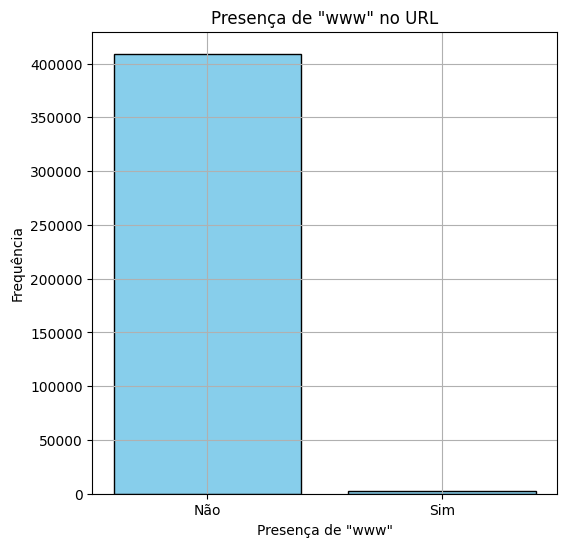

In [ ]:
plt.figure(figsize=(6, 6))
plt.bar(['Não', 'Sim'], Url_data_sem_ausentes['www_present'].value_counts(), color='skyblue', edgecolor='black')
plt.title('Presença de "www" no URL')
plt.xlabel('Presença de "www"')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


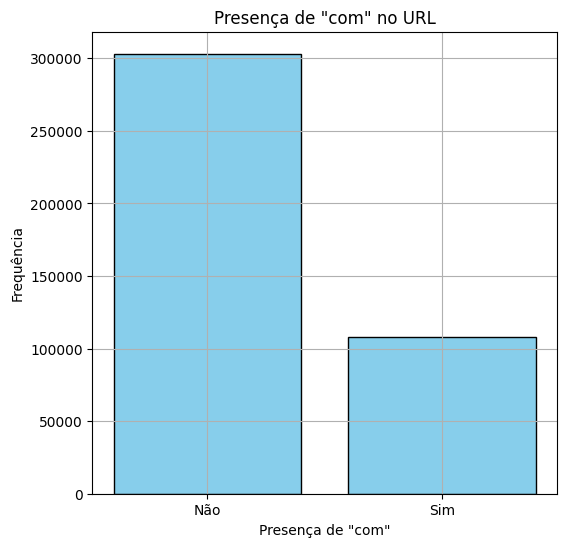

In [ ]:
plt.figure(figsize=(6, 6))
plt.bar(['Não', 'Sim'], Url_data_sem_ausentes['com_present'].value_counts(), color='skyblue', edgecolor='black')
plt.title('Presença de "com" no URL')
plt.xlabel('Presença de "com"')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

Grafico para função para contar caracteres consecutivos na URL

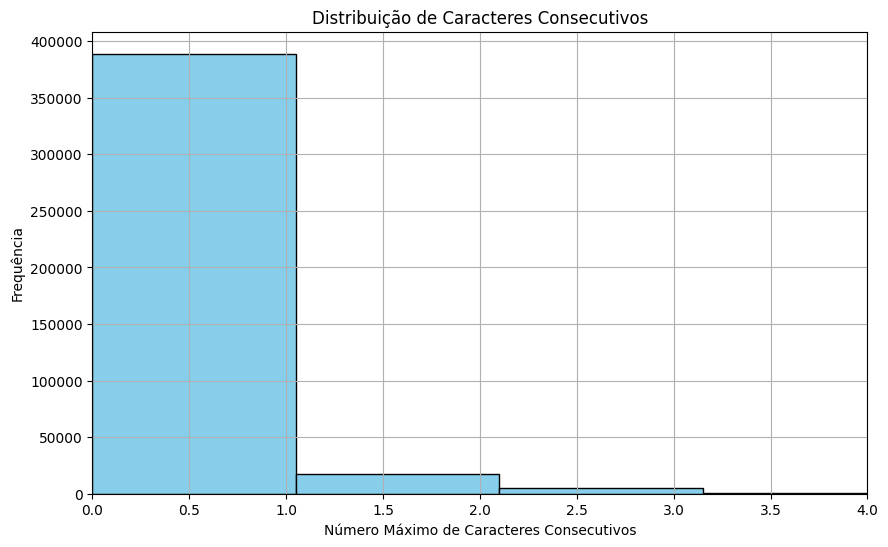

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(Url_data_sem_ausentes['consecutive_chars'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição de Caracteres Consecutivos')
plt.xlabel('Número Máximo de Caracteres Consecutivos')
plt.ylabel('Frequência')
plt.grid(True)

# Ajustando os limites do eixo x de acordo com os dados
plt.xlim(0, 4)
plt.show()


Grafico da função para verificar a utilização de punycode

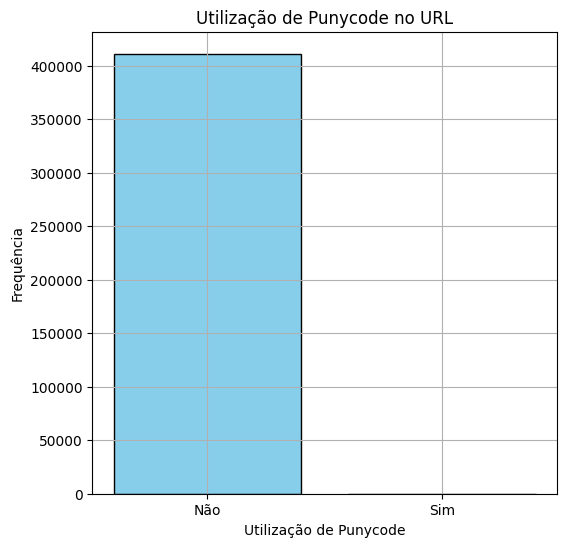

In [ ]:
plt.figure(figsize=(6, 6))
plt.bar(['Não', 'Sim'], Url_data_sem_ausentes['punycode'].value_counts(), color='skyblue', edgecolor='black')
plt.title('Utilização de Punycode no URL')
plt.xlabel('Utilização de Punycode')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


In [ ]:
# Criando base para modelos
colunas_df1 = ['url',	'label',	'symbols_count',	'digits_count',	'domain_entropy',	'tld', 'com_present']
colunas_df2 = ['max_word_length',	'min_word_length', 'famous_word_count']
url_model_data = pd.concat([Url_data_sem_ausentes[colunas_df1], Url_metrics[colunas_df2]], axis=1)


In [ ]:
# Arredondando a coluna 'domain_entropy' para 2 casas decimais
url_model_data['domain_entropy'] = url_model_data['domain_entropy'].round(2)

url_model_data

,url,label,symbols_count,digits_count,domain_entropy,tld,com_present,max_word_length,min_word_length,famous_word_count
0,diaryofagameaddict.com,malicious,1,0,1.69,com,True,18.0,3.0,0.0
1,espdesign.com.au,malicious,2,0,1.23,au,True,9.0,2.0,0.0
2,iamagameaddict.com,malicious,1,0,1.80,com,True,14.0,3.0,0.0
3,kalantzis.net,malicious,1,0,1.30,net,False,9.0,3.0,0.0
4,slightlyoffcenter.net,malicious,1,0,1.50,net,False,17.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
420459,23.227.196.215/,malicious,4,11,1.75,None,False,3.0,2.0,0.0
420460,apple-checker.org/,malicious,3,0,1.42,None,False,7.0,3.0,0.0
420461,apple-iclods.org/,malicious,3,0,1.23,None,False,6.0,3.0,0.0
420462,apple-uptoday.org/,malicious,3,0,1.31,None,False,7.0,3.0,0.0


### Arvore de decisão

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Supondo que 'Url_data_sem_ausentes' já esteja definido
X = Url_data_sem_ausentes['url']
y = Url_data_sem_ausentes['label']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Vetorizando os dados de entrada
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Treinando a árvore de decisão
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_tfidf, y_train)

# Selecionando algumas amostras para visualização
n_samples = 10  # Número de amostras para visualizar
sample_indices = list(range(n_samples))
sample_data = X_train_tfidf[sample_indices].toarray()
sample_labels = y_train.iloc[sample_indices].values

# Convertendo as amostras para DataFrame
sample_df = pd.DataFrame(sample_data, columns=vectorizer.get_feature_names_out())
sample_df['label'] = sample_labels

# Exibindo o DataFrame de amostras
print(sample_df)


In [ ]:
X = Url_data_sem_ausentes['url']
y = Url_data_sem_ausentes['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vetorizando os dados de entrada
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# Criando e treinando o modelo de árvore de decisão
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

In [ ]:
# Avaliando o desempenho do modelo
accuracy = dt.score(X_test, y_test)
print("Acurácia da Árvore de Decisão:", accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# Fazer previsões para o conjunto de teste
y_pred_teste = dt.predict(X_test)

# Vetorizar a nova URL
nova_url = ['google.xom/../../etc/pwd']
nova_url_transformada = vectorizer.transform(nova_url)

# Fazer previsões para a nova URL
previsao = dt.predict(nova_url_transformada)
print("Previsão para a nova URL:", previsao)

In [ ]:
# Calcular a matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred_teste)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

### Arvore de decisão com galhos definidos


In [ ]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Plotar a árvore
# plt.figure(figsize=(12, 8))
# plot_tree(dt, filled=True, feature_names=vectorizer.get_feature_names_out())
# plt.show()

In [ ]:
# Obter o caminho de decisão para os dados de entrada
decision_paths = dt.decision_path(X_train, check_input=True)

# Plotar a árvore de decisão em estilo monocromático
plt.figure(figsize=(12, 8))
plot_tree(dt, filled=False, feature_names=vectorizer.get_feature_names_out(), impurity=True, proportion = True)
plt.show()

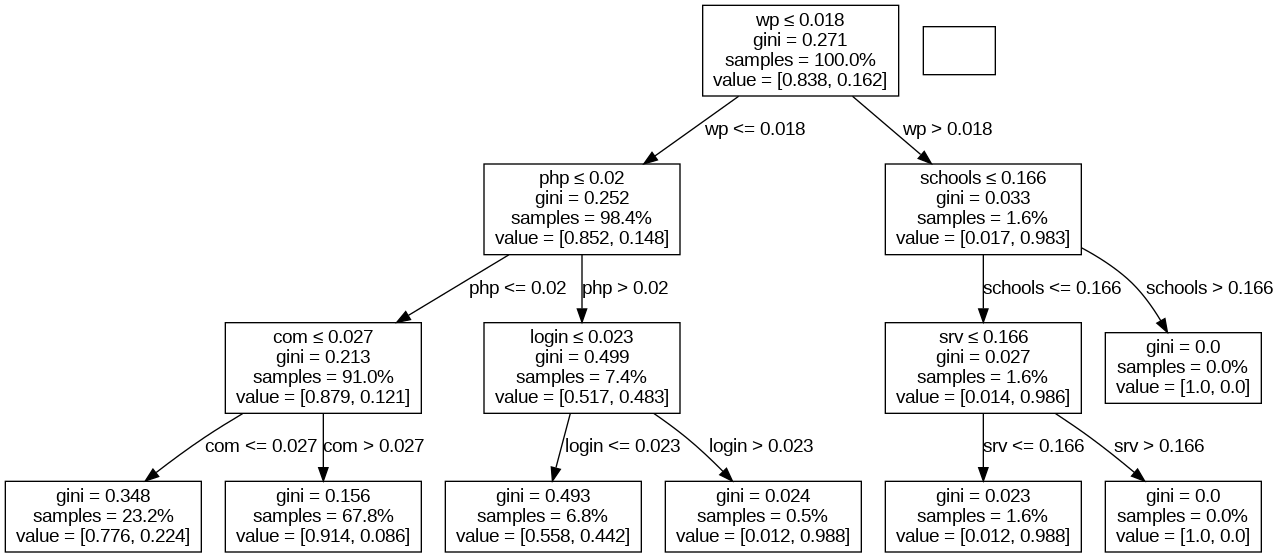

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image, display

# Exportar a árvore para o formato DOT
dot_data = export_graphviz(dt, out_file=None,
                           feature_names=vectorizer.get_feature_names_out(),
                           filled=False,
                           special_characters=True,
                           impurity=True,
                           proportion=True)

# Criar o gráfico a partir dos dados DOT
graph = pydotplus.graph_from_dot_data(dot_data)

lista_de_regras = []
for edge in graph.get_edges():
    src = edge.get_source()
    dst = edge.get_destination()
    src_node = graph.get_node(src)[0]
    dst_node = graph.get_node(dst)[0]

    # Obter a regra de divisão do nó de origem
    src_label = src_node.get_label().strip('"')
    rule = src_label.split('<br/>')[0]

    split1 = rule.split('<')
    split2 = split1[1].split(" ")

    if split2[0] not in lista_de_regras:
      new_rule = split2[0] + " " + "<=" + " " + split2[2]
      lista_de_regras.append(split2[0])
    else:
      new_rule = split2[0] + " " + ">" + " " + split2[2]

    edge.set_label(new_rule)

# Remover rótulos True e False
for edge in graph.get_edges():
    edge.set_headlabel("")
    edge.set_taillabel("")


# Visualizar a árvore de decisão
# graph.write_png('tree_with_edges_no_true_false.png')
display(Image(graph.create_png()))

In [ ]:
# Avaliando o desempenho do modelo
accuracy = dt.score(X_test, y_test)
print("Acurácia da Árvore de Decisão:", accuracy)

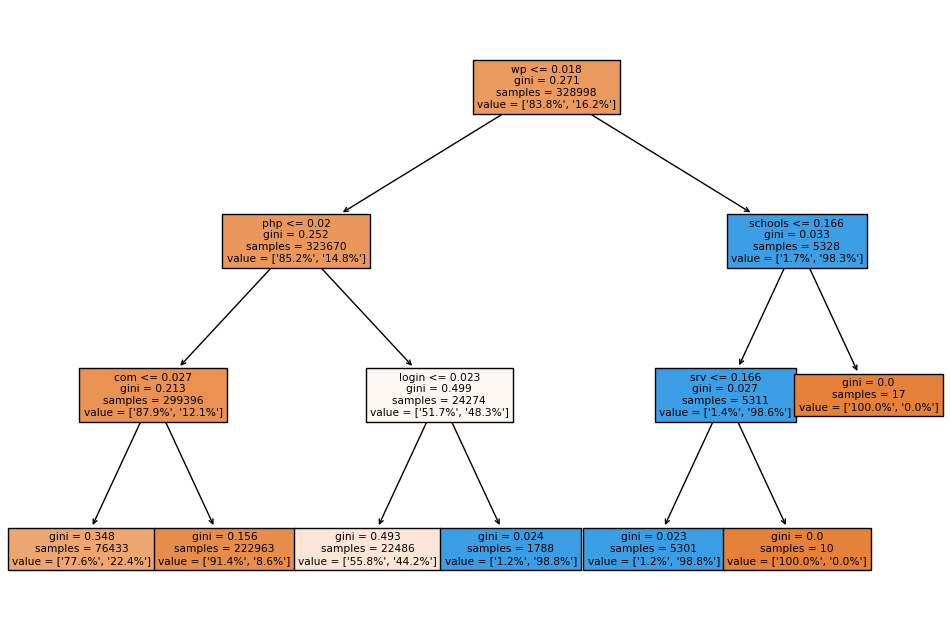

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np

# Supondo que X_train e y_train já estão definidos e o modelo já foi treinado
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

def get_class_percentages(tree):
    node_counts = tree.tree_.n_node_samples
    values = tree.tree_.value

    percentages = []
    for i in range(len(values)):
        value = values[i][0]
        value_sum = np.sum(value)
        percentages.append([f"{(v / value_sum) * 100:.1f}%" for v in value])

    return percentages

def plot_tree_with_percentages(model, feature_names):
    plt.figure(figsize=(12, 8))
    percentages = get_class_percentages(model)
    tree = plot_tree(model, filled=False, feature_names=feature_names)

    for i, text in enumerate(plt.gca().get_children()):
        if isinstance(text, plt.Text):
            if "value =" in text.get_text():
                text_lines = text.get_text().split("\n")
                new_text = "\n".join(text_lines[:-1] + [f'value = {percentages[i]}'])
                text.set_text(new_text)
    plt.show()

# Chame a função de plotagem personalizada
plot_tree_with_percentages(dt, feature_names=vectorizer.get_feature_names_out())


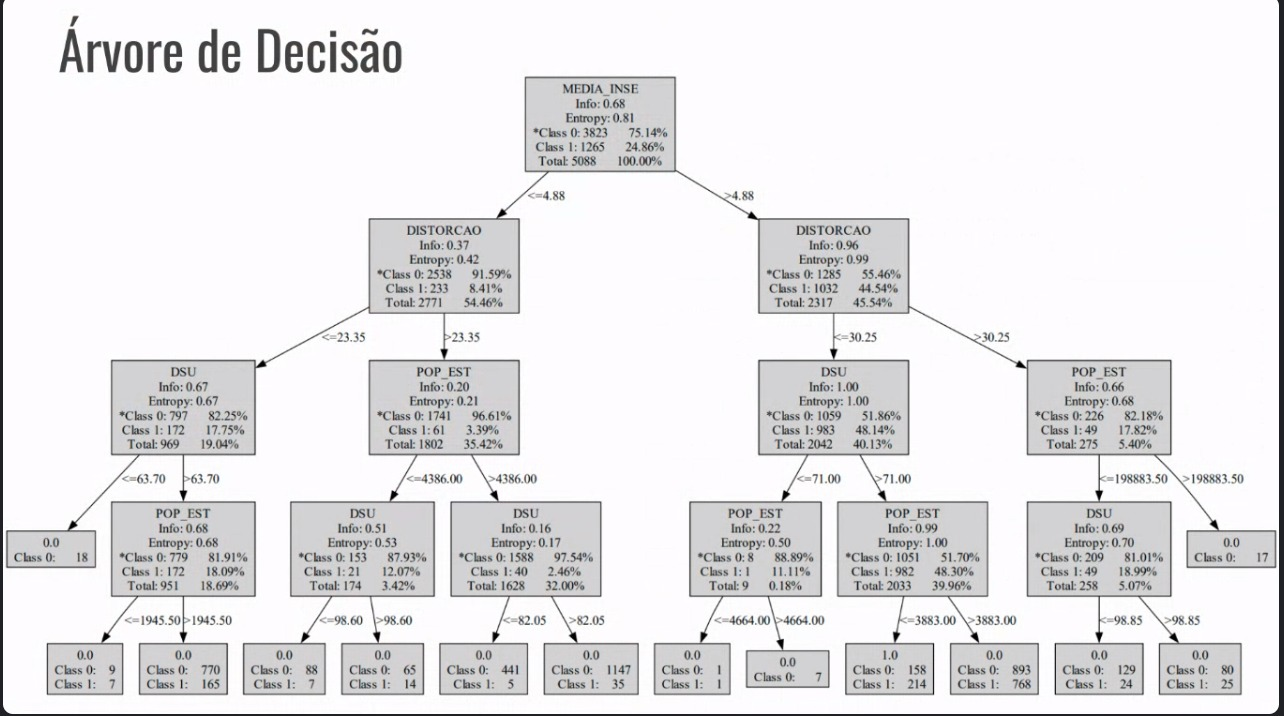

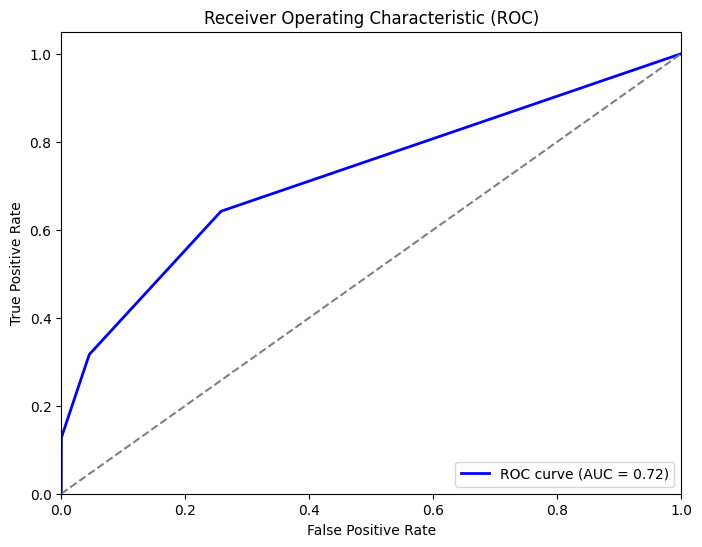

In [ ]:
# Mapear 'benign' para 0 e 'malicious' para 1 em y_test
y_test_binary = y_test.map({'benign': 0, 'malicious': 1})

# Calcule a curva ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

# Calcule a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Retirar variáveis que não servem

In [ ]:
Url_data_sem_ausentes

,url,label,symbols_count,digits_count,url_lengths,subdomain_level,domain_entropy,tld,www_present,com_present,word_metrics,consecutive_chars,punycode
0,diaryofagameaddict.com,malicious,1,0,[22],2,1.692308,com,False,True,"{'max_word_length': 18, 'min_word_length': 3, ...",1,False
1,espdesign.com.au,malicious,2,0,[16],3,1.230769,au,False,True,"{'max_word_length': 9, 'min_word_length': 2, '...",1,False
2,iamagameaddict.com,malicious,1,0,[18],2,1.800000,com,False,True,"{'max_word_length': 14, 'min_word_length': 3, ...",1,False
3,kalantzis.net,malicious,1,0,[13],2,1.300000,net,False,False,"{'max_word_length': 9, 'min_word_length': 3, '...",1,False
4,slightlyoffcenter.net,malicious,1,0,[21],2,1.500000,net,False,False,"{'max_word_length': 17, 'min_word_length': 3, ...",1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420459,23.227.196.215/,malicious,4,11,"[14, 0]",4,1.750000,None,False,False,"{'max_word_length': 3, 'min_word_length': 2, '...",1,False
420460,apple-checker.org/,malicious,3,0,"[17, 0]",2,1.416667,None,False,False,"{'max_word_length': 7, 'min_word_length': 3, '...",1,False
420461,apple-iclods.org/,malicious,3,0,"[16, 0]",2,1.230769,None,False,False,"{'max_word_length': 6, 'min_word_length': 3, '...",1,False
420462,apple-uptoday.org/,malicious,3,0,"[17, 0]",2,1.307692,None,False,False,"{'max_word_length': 7, 'min_word_length': 3, '...",1,False


Verificar as interessantes para o modelo: grau de entropia, tld, com_present, symbols_count, digits_count

falar de punnycode e outras na descritiva

In [ ]:
Url_metrics

,url,label,max_word_length,min_word_length,mean_word_length,std_word_length,total_words,compound_words,famous_word_count
0,diaryofagameaddict.com,malicious,18.0,3.0,10.50,7.50,2.0,2.0,0.0
1,espdesign.com.au,malicious,9.0,2.0,4.67,3.09,3.0,3.0,0.0
2,iamagameaddict.com,malicious,14.0,3.0,8.50,5.50,2.0,2.0,0.0
3,kalantzis.net,malicious,9.0,3.0,6.00,3.00,2.0,2.0,0.0
4,slightlyoffcenter.net,malicious,17.0,3.0,10.00,7.00,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
420459,23.227.196.215/,malicious,3.0,2.0,2.75,0.43,4.0,4.0,0.0
420460,apple-checker.org/,malicious,7.0,3.0,5.00,1.63,3.0,3.0,0.0
420461,apple-iclods.org/,malicious,6.0,3.0,4.67,1.25,3.0,3.0,0.0
420462,apple-uptoday.org/,malicious,7.0,3.0,5.00,1.63,3.0,3.0,0.0


Retirar mean_word_length	std_word_length	total_words	compound_words (para o modelo de regressão)

#### Explorando as Variáveis Gerais

Primeiramente vamos remover a variável www_present. Os sites hoje em dia já escondem o 'www', então já não é mais uma característica relevante para identificar phishing.

In [ ]:
Url_data_sem_ausentes.groupby('www_present')['label'].value_counts()

www_present  label    
False        benign       344748
             malicious     64429
True         malicious      2019
             benign           52
Name: count, dtype: int64

Analisando agora a categoria Punycode

In [ ]:
Url_data_sem_ausentes.groupby('punycode')['label'].value_counts()

punycode  label    
False     benign       344790
          malicious     66384
True      malicious        64
          benign           10
Name: count, dtype: int64

In [ ]:
Url_data_sem_ausentes.groupby('tld')['label'].value_counts()

tld    label    
0      benign       127
       malicious      9
00014  benign         1
001    benign        34
       malicious      1
                   ... 
zekri  benign         1
zhou   benign         1
ziari  benign         1
zip    malicious    217
zx     benign         1
Name: count, Length: 3231, dtype: int64

In [ ]:
Url_data_sem_ausentes.groupby('com_present')['label'].value_counts()

com_present  label    
False        benign        76963
             malicious     31105
True         benign       267837
             malicious     35343
Name: count, dtype: int64

In [ ]:
teste_url = Url_data_sem_ausentes

limites_caixas = [0, 10, 20, 30, 40, 50]  # Por exemplo, dividindo em caixas de tamanho 10

# Use pd.cut() para criar as caixas
teste_url['caixas'] = pd.cut(Url_data_sem_ausentes['symbols_count'], bins=limites_caixas)

# Agrupe os dados pelas caixas e conte as ocorrências de cada classe da variável binária
frequencia_classes = teste_url.groupby('caixas')['label'].value_counts()

# Visualize a frequência das classes dentro de cada caixa
print(frequencia_classes)

caixas    label    
(0, 10]   benign       308671
          malicious     58086
(10, 20]  benign        33806
          malicious      6194
(20, 30]  benign         2067
          malicious       997
(30, 40]  malicious       353
          benign          183
(40, 50]  malicious       635
          benign           57
Name: count, dtype: int64


In [ ]:
teste_url['caixas'] = pd.cut(Url_data_sem_ausentes['digits_count'], bins=limites_caixas)

# Agrupe os dados pelas caixas e conte as ocorrências de cada classe da variável binária
frequencia_classes = teste_url.groupby('caixas')['label'].value_counts()

# Visualize a frequência das classes dentro de cada caixa
print(frequencia_classes)

caixas    label    
(0, 10]   benign       149369
          malicious     25251
(10, 20]  benign        21574
          malicious      6876
(20, 30]  malicious      2994
          benign         2492
(30, 40]  malicious      1008
          benign          310
(40, 50]  malicious       736
          benign          141
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]  # Por exemplo, dividindo em caixas de tamanho 10

teste_url['caixas'] = pd.cut(Url_data_sem_ausentes['subdomain_level'], bins=limites_caixas)

# Agrupe os dados pelas caixas e conte as ocorrências de cada classe da variável binária
frequencia_classes = teste_url.groupby('caixas')['label'].value_counts()

# Visualize a frequência das classes dentro de cada caixa
print(frequencia_classes)

caixas   label    
(0, 2]   benign       252687
         malicious     41749
(2, 4]   benign        91024
         malicious     24093
(4, 6]   benign         1085
         malicious       385
(6, 8]   malicious       119
         benign            2
(8, 10]  malicious        61
         benign            2
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]  # Por exemplo, dividindo em caixas de tamanho 10

# Use pd.cut() para criar as caixas
teste_url['caixas'] = pd.cut(Url_data_sem_ausentes['domain_entropy'], bins=limites_caixas)

# Agrupe os dados pelas caixas e conte as ocorrências de cada classe da variável binária
frequencia_classes = teste_url.groupby('caixas')['label'].value_counts()

# Visualize a frequência das classes dentro de cada caixa
print(frequencia_classes)

caixas   label    
(0, 2]   benign       337711
         malicious     63422
(2, 4]   benign         7087
         malicious      2978
(4, 6]   malicious        37
         benign            2
(6, 8]   malicious        10
         benign            0
(8, 10]  malicious         1
         benign            0
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]  # Por exemplo, dividindo em caixas de tamanho 10

# Use pd.cut() para criar as caixas
teste_url['caixas'] = pd.cut(Url_data_sem_ausentes['consecutive_chars'], bins=limites_caixas)

# Agrupe os dados pelas caixas e conte as ocorrências de cada classe da variável binária
frequencia_classes = teste_url.groupby('caixas')['label'].value_counts()

# Visualize a frequência das classes dentro de cada caixa
print(frequencia_classes)

caixas   label    
(0, 2]   benign       343250
         malicious     62927
(2, 4]   malicious      3473
         benign         1509
(4, 6]   malicious        35
         benign           33
(6, 8]   malicious         8
         benign            6
(8, 10]  malicious         3
         benign            0
Name: count, dtype: int64


#### Explorando as Variáveis de Métrica

In [ ]:
teste_url_metrics = Url_metrics

limites_caixas = [0, 10, 20, 30, 40, 50]  # Por exemplo, dividindo em caixas de tamanho 10

# Use pd.cut() para criar as caixas
teste_url_metrics['caixas'] = pd.cut(Url_metrics['max_word_length'], bins=limites_caixas)

# Agrupe os dados pelas caixas e conte as ocorrências de cada classe da variável binária
frequencia_classes = teste_url_metrics.groupby('caixas')['label'].value_counts()

# Visualize a frequência das classes dentro de cada caixa
print(frequencia_classes)

caixas    label    
(0, 10]   benign       142571
          malicious     27089
(10, 20]  benign       171395
          malicious     28069
(20, 30]  benign        21592
          malicious      3185
(30, 40]  benign         5520
          malicious      5344
(40, 50]  benign         2031
          malicious       553
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]

teste_url_metrics['caixas'] = pd.cut(Url_metrics['min_word_length'], bins=limites_caixas)
frequencia_classes = teste_url_metrics.groupby('caixas')['label'].value_counts()
print(frequencia_classes)

caixas   label    
(0, 2]   benign       159043
         malicious     41310
(2, 4]   benign       185734
         malicious     25001
(4, 6]   malicious       101
         benign           23
(6, 8]   malicious        30
         benign            0
(8, 10]  malicious         2
         benign            0
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]

teste_url_metrics['caixas'] = pd.cut(Url_metrics['mean_word_length'], bins=limites_caixas)
frequencia_classes = teste_url_metrics.groupby('caixas')['label'].value_counts()
print(frequencia_classes)

caixas   label    
(0, 2]   malicious       117
         benign           24
(2, 4]   benign        17059
         malicious      7611
(4, 6]   benign       167284
         malicious     29053
(6, 8]   benign       107912
         malicious     18005
(8, 10]  benign        33133
         malicious      6795
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]

teste_url_metrics['caixas'] = pd.cut(Url_metrics['std_word_length'], bins=limites_caixas)
frequencia_classes = teste_url_metrics.groupby('caixas')['label'].value_counts()
print(frequencia_classes)

caixas   label    
(0, 2]   benign        49462
         malicious     11189
(2, 4]   benign       185736
         malicious     29732
(4, 6]   benign        66612
         malicious     12834
(6, 8]   benign        22829
         malicious      4305
(8, 10]  benign         9470
         malicious      2874
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]

teste_url_metrics['caixas'] = pd.cut(Url_metrics['total_words'], bins=limites_caixas)
frequencia_classes = teste_url_metrics.groupby('caixas')['label'].value_counts()
print(frequencia_classes)

caixas   label    
(0, 2]   benign        27584
         malicious      2490
(2, 4]   benign        67841
         malicious     18369
(4, 6]   benign       107872
         malicious     18780
(6, 8]   benign        59757
         malicious     10938
(8, 10]  benign        34548
         malicious      5860
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 2, 4, 6, 8, 10]

teste_url_metrics['caixas'] = pd.cut(Url_metrics['compound_words'], bins=limites_caixas)
frequencia_classes = teste_url_metrics.groupby('caixas')['label'].value_counts()
print(frequencia_classes)

caixas   label    
(0, 2]   benign        27731
         malicious      2674
(2, 4]   benign        81352
         malicious     18969
(4, 6]   benign       101658
         malicious     18895
(6, 8]   benign        57902
         malicious     10780
(8, 10]  benign        32998
         malicious      5929
Name: count, dtype: int64


In [ ]:
limites_caixas = [0, 1, 2, 3, 4, 5]

teste_url_metrics['caixas'] = pd.cut(Url_metrics['famous_word_count'], bins=limites_caixas)
frequencia_classes = teste_url_metrics.groupby('caixas')['label'].value_counts()
print(frequencia_classes)

caixas  label    
(0, 1]  malicious    3877
        benign        120
(1, 2]  malicious     869
        benign          3
(2, 3]  malicious      57
        benign          0
(3, 4]  malicious       5
        benign          0
(4, 5]  malicious       3
        benign          0
Name: count, dtype: int64


### Verificar as métricas (Geraldo)

mudar os numeros em cada folha para porcentagem

### Fazer um histograma com as variáveis da classe

Ao analisar a variável com mais calma, não faz sentindo construir um histograma para uma variável, para esse caso, é mais indicado ou fazer um gráfico de pizza ou um grafico de barras, logo abaixo eu vou colocar o gráfico de pizza e o de barras.

Gráfico de pizza

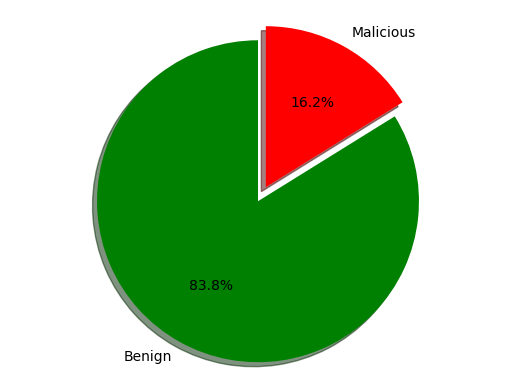

In [ ]:
# calculate the percentage of 'benign' and 'malicious' labels
label_counts = Url_data_sem_ausentes['label'].value_counts(normalize=True)
benign_percent = label_counts['benign'] * 100
malicious_percent = label_counts['malicious'] * 100

# create a pie chart
labels = ['Benign', 'Malicious']
sizes = [benign_percent, malicious_percent]
colors = ['green', 'red']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')

plt.show()

Grafico de barras

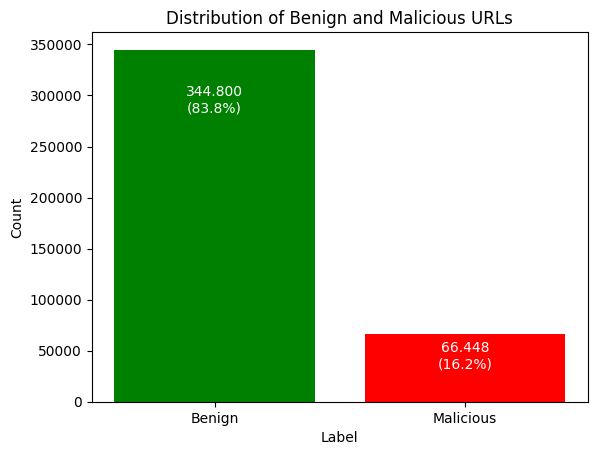

In [ ]:
import matplotlib.pyplot as plt

# Calcular a contagem dos rótulos novamente (se necessário)
label_counts = Url_data_sem_ausentes['label'].value_counts()

# Calcular a porcentagem dos rótulos
total = label_counts.sum()
benign_percent = (label_counts['benign'] / total) * 100
malicious_percent = (label_counts['malicious'] / total) * 100

# Definir os rótulos, contagens e porcentagens para o gráfico de barras
labels = ['Benign', 'Malicious']
counts = [label_counts['benign'], label_counts['malicious']]
percentages = [benign_percent, malicious_percent]
colors = ['green', 'red']

# Criar o gráfico de barras
bars = plt.bar(labels, counts, color=colors)

# Adicionar rótulos e porcentagens às barras
for bar, count, percentage in zip(bars, counts, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - height * 0.1,
             f'{count:,.0f}\n({percentage:.1f}%)'.replace(',', '.'),
             ha='center', va='top', color='white')

# Adicionar títulos e rótulos aos eixos
plt.title('Distribution of Benign and Malicious URLs')
plt.xlabel('Label')
plt.ylabel('Count')

# Mostrar o gráfico
plt.show()


### Ver se tem alguma estatística pra provar que o problema é relevante (Borges)

Ao analisar as possiveis tecnicas estatísticas para compreender se nossa amostra é suficente, é possivel realizar essas seguintes opções:



*   Testes de Significância Estatística
*   Intervalo de Confiança (para as metricas)
*   Curva de Aprendizado
*   Curva ROC e AUC
*   Potência do Teste


Sendo assim, ao visualizar como está a distribuição dos nossos dados é possivel utilizar logo de cara (**Curva ROC e AUC**) para analisar como os nossos resultados estão se comportanto com a distribuição das classes.

E também podemos testar cénarios de balanceamento de dados e assim verificar o impacto dos resultados.



*   **downsampling** : amostras são removidas aleatoriamente da classe majoritária até que o tamanho da classe majoritária corresponda ao tamanho da classe minoritária
*   **upsampling** : amostras são replicadas ou novas amostras são geradas na classe minoritária até que o tamanho da classe minoritária corresponda ao tamanho da classe majoritária.

*   **SMOTE** : cria novas amostras sintéticas interpolando entre amostras minoritárias próximas. Para cada amostra minoritária, o algoritmo encontra seus k vizinhos mais próximos na mesma classe e gera novas amostras interpolando entre a amostra original e seus vizinhos





### Regressão logística

In [ ]:
url_model_data.head()

,url,label,symbols_count,digits_count,domain_entropy,tld,com_present,max_word_length,min_word_length,famous_word_count
0,diaryofagameaddict.com,malicious,1,0,1.69,com,True,18.0,3.0,0.0
1,espdesign.com.au,malicious,2,0,1.23,au,True,9.0,2.0,0.0
2,iamagameaddict.com,malicious,1,0,1.80,com,True,14.0,3.0,0.0
3,kalantzis.net,malicious,1,0,1.30,net,False,9.0,3.0,0.0
4,slightlyoffcenter.net,malicious,1,0,1.50,net,False,17.0,3.0,0.0


In [ ]:
# Remover a coluna "url"
df_model = url_model_data.drop(columns=['url'])

In [ ]:
df_model.head()

,label,symbols_count,digits_count,domain_entropy,tld,com_present,max_word_length,min_word_length,famous_word_count
0,malicious,1,0,1.69,com,True,18.0,3.0,0.0
1,malicious,2,0,1.23,au,True,9.0,2.0,0.0
2,malicious,1,0,1.80,com,True,14.0,3.0,0.0
3,malicious,1,0,1.30,net,False,9.0,3.0,0.0
4,malicious,1,0,1.50,net,False,17.0,3.0,0.0


## Árvore com os Mesmos dados da Regressão

In [ ]:
df_model

,label,symbols_count,digits_count,domain_entropy,tld,com_present,max_word_length,min_word_length,famous_word_count
0,malicious,1,0,1.69,com,True,18.0,3.0,0.0
1,malicious,2,0,1.23,au,True,9.0,2.0,0.0
2,malicious,1,0,1.80,com,True,14.0,3.0,0.0
3,malicious,1,0,1.30,net,False,9.0,3.0,0.0
4,malicious,1,0,1.50,net,False,17.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...
420459,malicious,4,11,1.75,None,False,3.0,2.0,0.0
420460,malicious,3,0,1.42,None,False,7.0,3.0,0.0
420461,malicious,3,0,1.23,None,False,6.0,3.0,0.0
420462,malicious,3,0,1.31,None,False,7.0,3.0,0.0


In [ ]:
# Supondo que 'Url_data_sem_ausentes' já esteja definido
df_model['label'] = df_model['label'].map({'malicious': 1, 'benign': 0})

In [ ]:
X = df_model.drop(['label', 'tld'], axis = 1)
y = df_model['label']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando a árvore de decisão
clf = DecisionTreeClassifier(random_state=42, max_depth = 3)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

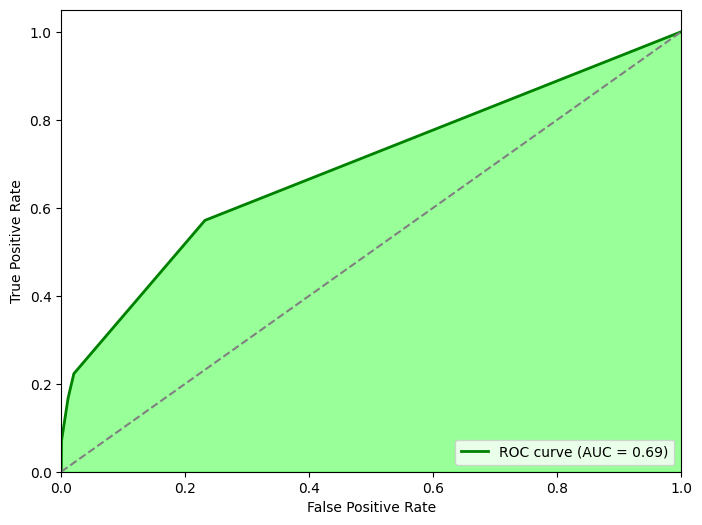

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = clf.predict_proba(X_test)[:, 1]

# Calcule a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcule a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, color='lime', alpha=0.4)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc='lower right')
plt.show()

### Árvore restrita

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image, display

clf_res = DecisionTreeClassifier(max_depth = 3, random_state=42)
clf_res.fit(X_train, y_train)

print(clf_res.criterion)

gini


<famous_word_count &le; 0.5
<com_present &le; 0.5
<digits_count &le; 10.5
<digits_count &le; 10.5
<com_present &le; 0.5
<digits_count &le; 18.5
<digits_count &le; 18.5
<famous_word_count &le; 0.5
<symbols_count &le; 4.5
<com_present &le; 0.5
<com_present &le; 0.5
<symbols_count &le; 4.5
<digits_count &le; 10.5
<digits_count &le; 10.5


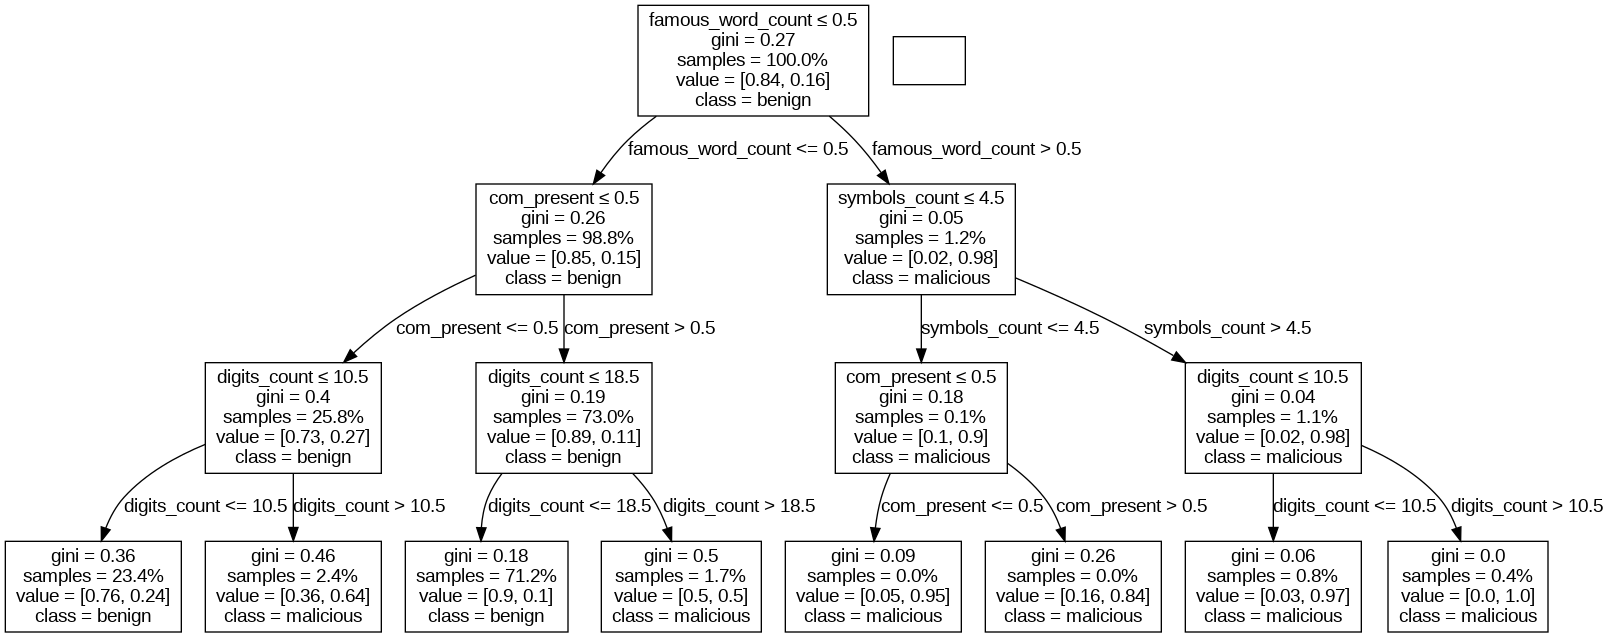

In [ ]:
# Exportar a árvore para o formato DOT
dot_data = export_graphviz(clf_res, out_file=None,
                           feature_names=X.columns,
                           filled=False,
                           special_characters=True,
                           impurity=True,
                           proportion=True,
                           class_names = ['benign', 'malicious'],
                           precision=2)

# Criar o gráfico a partir dos dados DOT
graph = pydotplus.graph_from_dot_data(dot_data)

lista_de_regras = []
for edge in graph.get_edges():
    src = edge.get_source()
    dst = edge.get_destination()
    src_node = graph.get_node(src)[0]
    dst_node = graph.get_node(dst)[0]

    # Obter a regra de divisão do nó de origem
    src_label = src_node.get_label().strip('"')
    rule = src_label.split('<br/>')[0]
    print(rule)

    split1 = rule.split('<')
    split2 = split1[1].split(" ")


    if split2[0] not in lista_de_regras or lista_de_regras.count(split2[0])%2 == 0:
      new_rule = split2[0] + " " + "<=" + " " + split2[2]
    else:
      new_rule = split2[0] + " " + ">" + " " + split2[2]
    lista_de_regras.append(split2[0])

    edge.set_label(new_rule)

# Remover rótulos True e False
for edge in graph.get_edges():
    edge.set_headlabel("")
    edge.set_taillabel("")


# Visualizar a árvore de decisão
# graph.write_png('tree_with_edges_no_true_false.png')
display(Image(graph.create_png()))

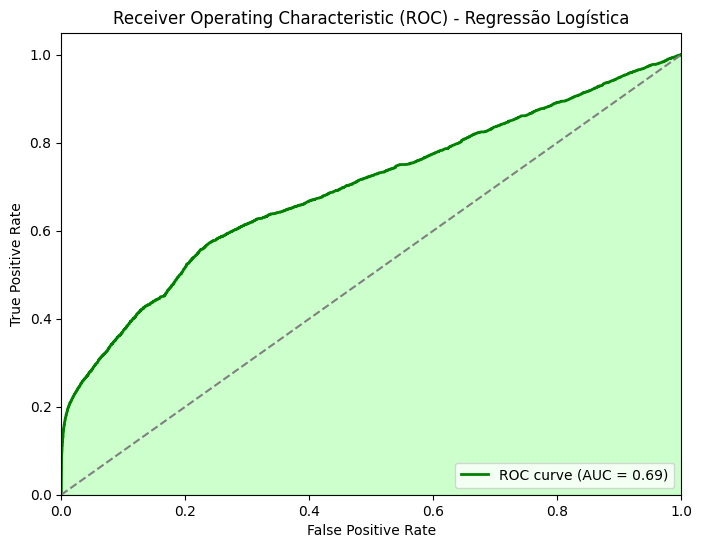

In [ ]:
from sklearn.linear_model import LogisticRegression

# Treinando a regressão logística
logreg = LogisticRegression(random_state=42, max_iter=10000)
logreg.fit(X_train, y_train)

# Prever as probabilidades das classes para o conjunto de teste
y_prob = logreg.predict_proba(X_test)[:, 1]

# Calcule a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcule a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, color='lime', alpha=0.2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Regressão Logística')
plt.legend(loc='lower right')
plt.show()